##### small working logs:

The matching kernel is created by the photutils api. This function calculates the fraction of the 2 psfs in the forier domain, which is however highly sensitive to the high frequency noise. Several window function is provided for filering out and thus the shape of the psf is dependent on how strong we filter out the high frequency noise. In the sanity test I've fitted for each psf and matching kernel a 2d gaussian and check their FWHM. The matching kernel is also convolved with hb psf and its fit results compared with ha. The goal is to minimize the fwhm difference of the kernel convoled hb and ha by adjusting the frequency windows step by step manually.

In [1]:
import numpy                as np
from   scripts.tools        import *
from   astropy.table        import Table
from   astropy.io           import fits
from   astropy.convolution  import convolve_fft 
from   scipy.optimize       import curve_fit
from   tqdm                 import tqdm
import matplotlib.pyplot    as     plt
from   mpl_toolkits.mplot3d import Axes3D
from   astropy.io           import fits
import matplotlib.colors    as     colors
from   photutils.psf        import matching as match
from   IPython.display      import clear_output
import inspect


#generate matching kernel for psf_ha & psf_hb
def gen_kernel(psf_hb,psf_ha,window=match.CosineBellWindow,alpha=3,beta=0.9):
        
        if window==None:
                kernel = fits.ImageHDU(
                data = match.create_matching_kernel(psf_hb.data,psf_ha.data),
                name = 'PSF_MATCH')
                kernel.data = kernel.data/np.sum(kernel.data)
                return kernel 
        
        if len(inspect.signature(window).parameters) == 0:
            window = window()
        elif len(inspect.signature(window).parameters) == 1:
            window = window(alpha)
        elif len(inspect.signature(window).parameters) == 2:
            window = window(alpha,beta)

        kernel = fits.ImageHDU(
                data = match.create_matching_kernel(psf_hb.data,psf_ha.data,window=window),
                name = 'PSF_MATCH')
        kernel.data = kernel.data/np.sum(kernel.data)
        return kernel 


# Define the 2D Gaussian function for data fitting
def gaussian_2d(x, y, amplitude, fwhm, x0, y0, c):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amplitude * np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)) + c


# Fit the 2D Gaussian function to a imagehdu
def fit_gaussian_2d(image):
    size_x, size_y = image.shape
    x = np.linspace(0, size_x - 1, size_x)
    y = np.linspace(0, size_y - 1, size_y)
    x, y = np.meshgrid(x, y)
    initial_guess = (np.max(image.data), 2, 24.5, 24.5,0.01)
    popt, pcov = curve_fit(
        lambda xy, amplitude, fwhm, x0, y0, c: gaussian_2d(xy[0], xy[1], amplitude, fwhm, x0, y0, c), (x.ravel(), y.ravel()), image.data.ravel(), p0=initial_guess)
    return popt



#  check psfs and matching kernel

[2.09189743e-01 1.60904813e+00 2.49941817e+01 2.50123643e+01
 1.51907869e-04]


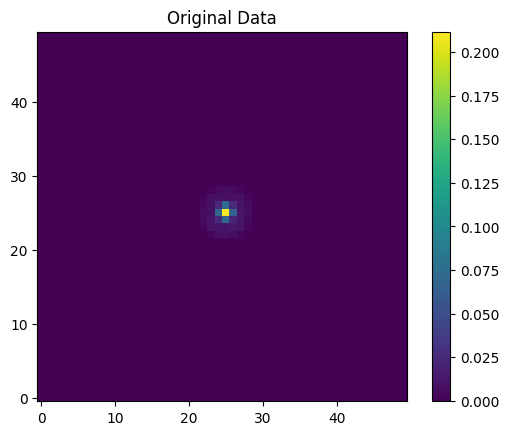

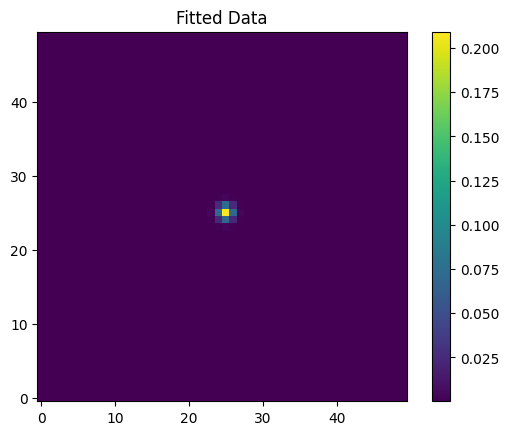

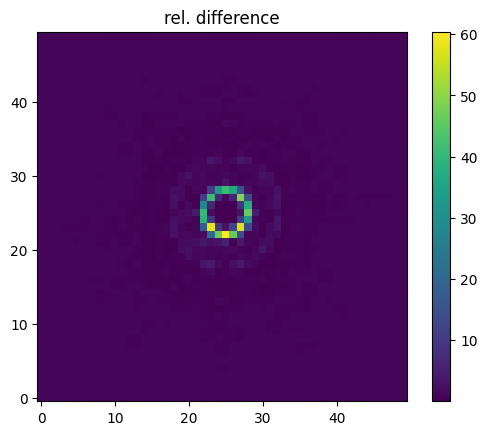

In [2]:
%matplotlib inline
with fits.open('psf/combined_psf/ERSPRIME_38832_hb.fits') as hdu:
        image_data = hdu[1].data
        popt = fit_gaussian_2d(hdu[1])
        print(popt)

        # Plot original data
        plt.figure()
        plt.imshow(image_data, origin='lower', cmap='viridis')
        plt.colorbar()
        plt.title('Original Data')

        # Generate fitted data
        size_x, size_y = image_data.shape
        x = np.linspace(0, size_x - 1, size_x)
        y = np.linspace(0, size_y - 1, size_y)
        x, y = np.meshgrid(x, y)
        fitted_data = gaussian_2d(x, y, *popt)

        # Plot fitted data
        plt.figure()
        plt.imshow(fitted_data, origin='lower', cmap='viridis')
        plt.colorbar()
        plt.title('Fitted Data')
        plt.show()

        plt.imshow(np.abs(fitted_data - image_data)/fitted_data, 
                #norm = colors.LogNorm(),
                origin='lower', cmap='viridis')
        plt.colorbar()
        plt.title('rel. difference')

### fit gaussian to psfs and check FWHM

100%|██████████| 158/158 [00:03<00:00, 42.62it/s]


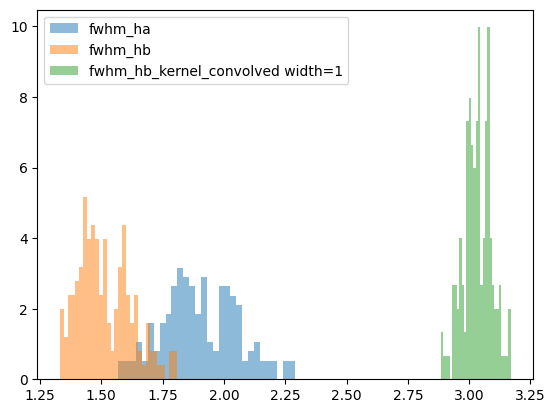

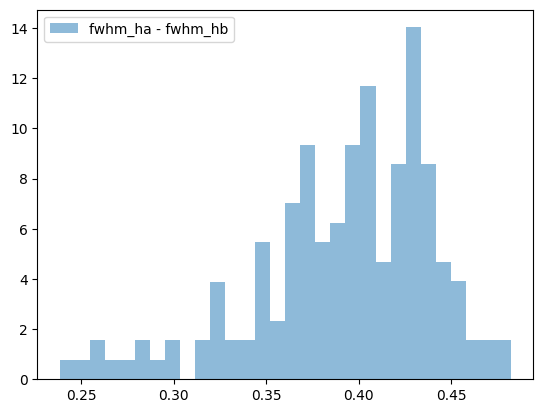

100%|██████████| 158/158 [00:02<00:00, 56.89it/s]


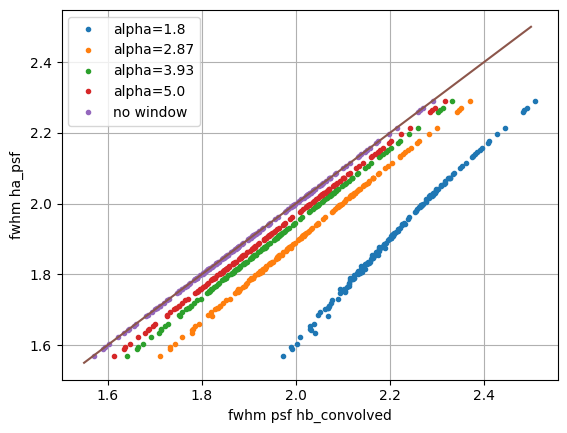

In [3]:
# compute fwhm for psfs and kernels of one object and compare
def psf_check(obj,
              window=match.CosineBellWindow,
              alpha=0.5,beta=0.9):
    
    #matching kernel and fit 2d gaussian
    #path for combined psf
    path_to_psf = f"psf/combined_psf/{obj['subfield']}_{obj['id']}"

    #open and update extracted file, add psf_kernel
    psf_ha = fits.open(f'{path_to_psf}_ha.fits')[1]
    psf_hb = fits.open(f'{path_to_psf}_hb.fits')[1]
    kernel = gen_kernel(psf_hb,psf_ha,window,alpha,beta)
    popt_kernel = fit_gaussian_2d(kernel)
    kernel.writeto(f"psf/matching_kernel/{obj['subfield']}_{obj['id']}.fits",overwrite=True)

    #load psf images and fit 2d gaussian
    hdu_ha = fits.open(f"psf/combined_psf/{obj['subfield']}_{obj['id']}_ha.fits")[1]
    popt_ha = fit_gaussian_2d(hdu_ha)

    hdu_hb = fits.open(f"psf/combined_psf/{obj['subfield']}_{obj['id']}_hb.fits")[1]
    popt_hb = fit_gaussian_2d(hdu_hb)


    #for hb images we also need to convolve with the matching kernel and check the fwhm
    hb_kernel_convolved = fits.ImageHDU(data = convolve_fft(hdu_hb.data,kernel.data),
                                                header=hdu_hb.header, name= 'HB_kernel_CONV')
    popt_hb_convolved   = fit_gaussian_2d(hb_kernel_convolved)
    return [obj['subfield'],obj['id'],*popt_ha, *popt_hb,*popt_kernel,*popt_hb_convolved]

#call psf_fit function, cat process, gen fit results table
def cat_process_psf_fit(
        window=match.CosineBellWindow,
        alpha=0.5,beta=0.9):
    
    col_names = ['subfield','id',
                 'amplitude_ha', 'fwhm_ha', 'x0_ha', 'y0_ha', 'c_ha', 
                 'amplitude_hb', 'fwhm_hb', 'x0_hb', 'y0_hb', 'c_hb', 
                 'amplitude_kernel', 'fwhm_kernel', 'x0_kernel', 'y0_kernel', 'c_kernel',
                 'amplitude_hb_conv', 'fwhm_hb_conv', 'x0_hb_conv', 'y0_hb_conv', 'c_hb_conv']
    
    obj_lis = Table.read('obj_lis_selected.fits')
    rows = []
    for obj in tqdm(obj_lis):
        rows.append(psf_check(obj,window,alpha,beta))
    fitresults = Table(rows=rows,names=col_names)
    fitresults.write('psf/psf_initial_fitresults.fits',overwrite=True)
    return fitresults
    
def main():
    #plot fwhm of psf_ha, psf_hb and psf_hb_convolved
    #initial test waith just a limit waindow width alpha=1
    psf_results = cat_process_psf_fit(alpha=1)
    fwhm_diff   = psf_results['fwhm_ha'] - psf_results['fwhm_hb']
    plt.hist(psf_results['fwhm_ha']     ,bins=30,density=True,alpha=0.5,label='fwhm_ha')
    plt.hist(psf_results['fwhm_hb']     ,bins=30,density=True,alpha=0.5,label='fwhm_hb')
    plt.hist(psf_results['fwhm_hb_conv'],bins=30,density=True,alpha=0.5,label='fwhm_hb_kernel_convolved width=1')
    plt.legend();plt.show()
    plt.hist(fwhm_diff ,bins=30,density=True,alpha=0.5,label='fwhm_ha - fwhm_hb')
    plt.legend();plt.show()

    
    alphas = np.linspace(1.8,5,4)
    for alpha in alphas:
        psf_results = cat_process_psf_fit(alpha=alpha)
        plt.plot(psf_results['fwhm_hb_conv'],psf_results['fwhm_ha'],marker='.',linewidth=0,label=f'alpha={round(alpha,2)}')

    psf_results = cat_process_psf_fit(window=match.TopHatWindow,alpha=2)
    plt.plot(psf_results['fwhm_hb_conv'],psf_results['fwhm_ha'],marker='.',linewidth=0,label='no window')
    
    plt.plot([1.55,2.5],[1.55,2.5])
    plt.xlabel('fwhm psf hb_convolved');plt.ylabel('fwhm ha_psf')
    plt.legend();plt.grid();plt.show()

if __name__ == '__main__':
    main()

100%|██████████| 158/158 [00:03<00:00, 47.84it/s]


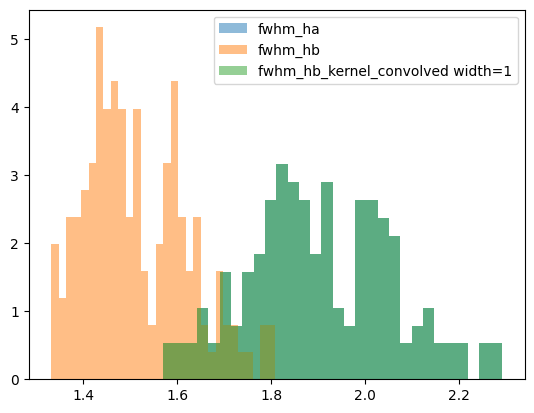

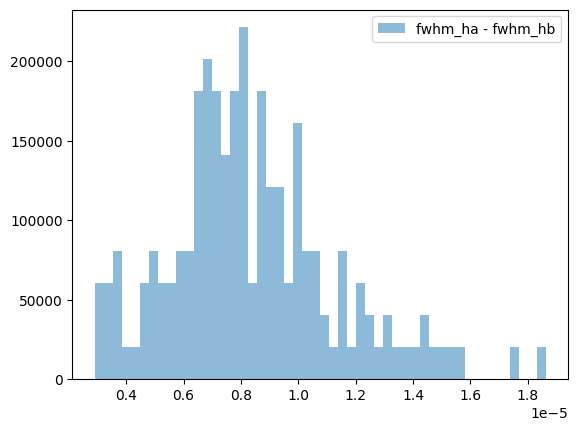

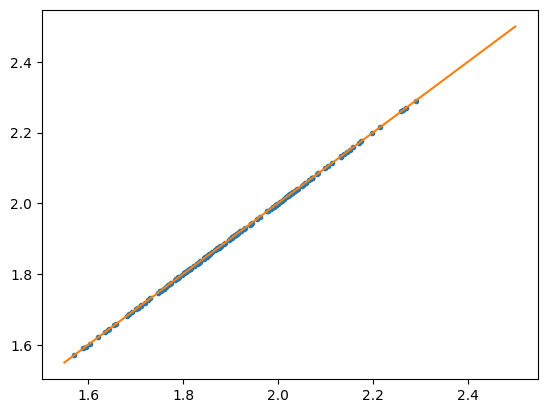

In [4]:
psf_results = cat_process_psf_fit(window=None, beta=0.4,alpha=10)
fwhm_diff   = psf_results['fwhm_hb_conv'] - psf_results['fwhm_ha']
plt.hist(psf_results['fwhm_ha']     ,bins=30,density=True,alpha=0.5,label='fwhm_ha')
plt.hist(psf_results['fwhm_hb']     ,bins=30,density=True,alpha=0.5,label='fwhm_hb')
plt.hist(psf_results['fwhm_hb_conv'],bins=30,density=True,alpha=0.5,label='fwhm_hb_kernel_convolved width=1')
plt.legend();plt.show()
plt.hist(fwhm_diff ,bins=50,density=True,alpha=0.5,label='fwhm_ha - fwhm_hb')
plt.legend();plt.show()
plt.plot(psf_results['fwhm_hb_conv'],psf_results['fwhm_ha'],marker='.',linewidth=0)
plt.plot([1.55,2.5],[1.55,2.5])


### best matching kernel: no windows

In [5]:
obj_lis = Table.read('obj_lis_selected.fits')
index=2
def plot_psf(obj):
        path_to_psf = f"psf/combined_psf/{obj['subfield']}_{obj['id']}"
        psf_ha = fits.open(f'{path_to_psf}_ha.fits')[1]
        psf_hb = fits.open(f'{path_to_psf}_hb.fits')[1]
        #window = match.SplitCosineBellWindow(alpha=5, beta=0.5)
        window = None
        kernel = fits.ImageHDU(
                data = match.create_matching_kernel(psf_hb.data,psf_ha.data,window=window),
                name = 'PSF_MATCH')
        kernel.data = kernel.data/np.sum(kernel.data)
        psf_hb_conv = fits.ImageHDU(data = convolve_fft(psf_hb.data,kernel.data),header=psf_hb.header, name= 'HB_kernel_CONV')

        '''
        print('kernel')
        plt.imshow(kernel.data);plt.colorbar();plt.show()
        print('ha')
        plt.imshow(psf_ha.data);plt.colorbar();plt.show()
        print('hb_conv')
        plt.imshow(psf_hb_conv.data);plt.colorbar();plt.show()
        print('hb')
        plt.imshow(psf_hb.data);plt.colorbar();plt.show()


        popt_hb_conv = fit_gaussian_2d(psf_hb_conv)
        popt_ha = fit_gaussian_2d(psf_ha)

        print(popt_hb_conv)
        print(popt_ha)

        print('kernel')
        plt.imshow(kernel.data,norm=colors.LogNorm());plt.colorbar();plt.show()
        print('ha')
        plt.imshow(psf_ha.data,norm=colors.LogNorm());plt.colorbar();plt.show()
        psf_hb_conv = fits.ImageHDU(data = convolve_fft(psf_hb.data,kernel.data),header=psf_hb.header, name= 'HB_kernel_CONV')
        print('hb')
        plt.imshow(psf_hb.data,norm=colors.LogNorm());plt.colorbar();plt.show()
        print('hb_conv')
        plt.imshow(psf_hb_conv.data,norm=colors.LogNorm());plt.colorbar();plt.show()
        '''

        plt.imshow(np.abs(psf_hb_conv.data-psf_ha.data)/psf_ha.data,norm=colors.LogNorm())
        plt.title('rel. difference')
        plt.colorbar();plt.savefig(f"psf/fit_results/{obj['subfield']}_{obj['id']}_diff")
        plt.show();plt.close()

        # Create a figure with multiple subplots
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        # Plot kernel
        axs[0, 0].imshow(kernel.data)
        axs[0, 0].set_title('kernel')
        fig.colorbar(axs[0, 0].images[0], ax=axs[0, 0])

        # Plot ha
        axs[0, 1].imshow(psf_ha.data)
        axs[0, 1].set_title('ha')
        fig.colorbar(axs[0, 1].images[0], ax=axs[0, 1])

        # Plot hb_conv
        axs[0, 2].imshow(psf_hb_conv.data)
        axs[0, 2].set_title('hb_conv')
        fig.colorbar(axs[0, 2].images[0], ax=axs[0, 2])

        # Plot hb
        axs[0, 3].imshow(psf_hb.data)
        axs[0, 3].set_title('hb')
        fig.colorbar(axs[0, 3].images[0], ax=axs[0, 3])

        # Perform Gaussian fitting
        popt_hb_conv = fit_gaussian_2d(psf_hb_conv)
        popt_ha = fit_gaussian_2d(psf_ha)

        print(popt_hb_conv)
        print(popt_ha)

        # Plot kernel with LogNorm
        axs[1, 0].imshow(kernel.data, norm=colors.LogNorm())
        axs[1, 0].set_title('kernel (LogNorm)')
        fig.colorbar(axs[1, 0].images[0], ax=axs[1, 0])

        # Plot ha with LogNorm
        axs[1, 1].imshow(psf_ha.data, norm=colors.LogNorm())
        axs[1, 1].set_title('ha (LogNorm)')
        fig.colorbar(axs[1, 1].images[0], ax=axs[1, 1])

        # Perform convolution
        psf_hb_conv = fits.ImageHDU(data=convolve_fft(psf_hb.data, kernel.data), header=psf_hb.header, name='HB_kernel_CONV')

        # Plot hb with LogNorm
        axs[1, 2].imshow(psf_hb.data, norm=colors.LogNorm())
        axs[1, 2].set_title('hb (LogNorm)')
        fig.colorbar(axs[1, 2].images[0], ax=axs[1, 2])

        # Plot hb_conv with LogNorm
        axs[1, 3].imshow(psf_hb_conv.data, norm=colors.LogNorm())
        axs[1, 3].set_title('hb_conv (LogNorm)')
        fig.colorbar(axs[1, 3].images[0], ax=axs[1, 3])

        # Adjust layout
        plt.tight_layout()
        plt.savefig(f"psf/fit_results/{obj['subfield']}_{obj['id']}")
        plt.show()
        clear_output(wait=True)
        return f"obj['subfield']_{obj['id']}_plotted"
for obj in tqdm(obj_lis):
    plot_psf(obj)


100%|██████████| 158/158 [08:26<00:00,  3.21s/it]


#### Here I found that without window filtering the kernels gives the most sensible result

###  matching psf + hb convolving with optimized parameter (i.e. no window function)

In [2]:
#find specific entry in the hdu

#this small fucntion will save the updated image to the extracted file 
def save_update(image_to_save,extracted):
        for i,image in enumerate(extracted):
            if image.name == image_to_save.name:
                extracted[i] = image_to_save
                return extracted
        extracted.append(image_to_save)
        extracted.flush()
        return extracted

def match_psf(obj):
    print(obj)
    #path for extracted hdu list and combined psf
    path        = f"data_extracted/{file_name(obj,prefix='extracted')}"
    path_to_psf = f"psf/combined_psf/{obj['subfield']}_{obj['id']}"

    #open and update extracted file, add psf_kernel
    with fits.open(path,mode='update') as extracted:
        psf_ha = fits.open(f'{path_to_psf}_ha.fits')[1]
        psf_hb = fits.open(f'{path_to_psf}_hb.fits')[1]
        kernel = gen_kernel(psf_hb,psf_ha,window=None)
        
        #convolve hb linemap
        hb     = find_data('LINE_HB',extracted)[1]
        hb_convolve = fits.ImageHDU(data = convolve_fft(hb.data,kernel.data),
        header = hb.header,name = 'LINE_HB_CONV')

        #cnvolve hb weight map
        hb_wht = find_data('LINEWHT_HB',extracted)[1]
        hb_wht_convolve = fits.ImageHDU(data = convolve_fft(hb_wht.data,kernel.data),
        header = hb_wht.header,name = 'LINEWHT_HB_CONV')

        #also do a background subtraction for the convoled image
        hb_convolve_bg = fits.ImageHDU(data = hb_convolve.data - np.median(hb_convolve.data),
        header = hb.header,name = 'LINE_HB_CONV_BG')

        # either update or add data to HDUlist
        extracted = save_update(kernel          ,extracted)
        extracted = save_update(hb_convolve     ,extracted)
        extracted = save_update(hb_wht_convolve ,extracted)
        extracted = save_update(hb_convolve_bg  ,extracted)

        
        #update
        extracted.flush()
        clear_output(wait=True)
        return f"{obj['subfield']}_{obj['id']} processed"


from concurrent.futures     import ThreadPoolExecutor, as_completed
def cat_process_match_psf(obj_lis,max_threads=1):
    results = []
    if max_threads>1:
        with ThreadPoolExecutor(max_threads) as executor:
            futures = {executor.submit(match_psf,obj):obj for obj in obj_lis}
            for future in tqdm(as_completed(futures), total=len(obj_lis), desc="Processing"):
                results.append(future.result())
        return results
    else:
        for obj in tqdm(obj_lis):
            results.append(match_psf(obj))
        return results

if __name__ == '__main__':
    obj_lis = Table.read('obj_lis_selected.fits')
    results = cat_process_match_psf(obj_lis,max_threads=6)
    number = 0
    for result in results:
        if 'error' in result:
            number +=1
            print(result)
    print('total number of obj processed:',len(results))
    print('number of failed obj',number)

Processing: 100%|██████████| 158/158 [03:47<00:00,  1.44s/it]

total number of obj processed: 158
number of failed obj 0
